<a href="https://colab.research.google.com/github/CarsonSwa1/491CV-SuperResolution/blob/main/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
#download the trained model
!gdown 1-K_tCMQwwn5nbbga27kXSHCqWDa6QquM

#download sample pictures
!gdown 1egQEj2t_USXBLCQjCqKEPY5-oErLnISh
!gdown 1gRQ-nt1yDK0O9UYkI01Assjbu1t2St8e
!gdown 1m8YUnkXVqOmUkSu993MoquZE7Gga3J_W

Downloading...
From (original): https://drive.google.com/uc?id=1-K_tCMQwwn5nbbga27kXSHCqWDa6QquM
From (redirected): https://drive.google.com/uc?id=1-K_tCMQwwn5nbbga27kXSHCqWDa6QquM&confirm=t&uuid=0b7968a7-de04-4a9a-8b12-aaeb8653979b
To: /content/good_model.pt
100% 314M/314M [00:01<00:00, 216MB/s]
Downloading...
From: https://drive.google.com/uc?id=1egQEj2t_USXBLCQjCqKEPY5-oErLnISh
To: /content/koala.png
100% 10.7k/10.7k [00:00<00:00, 22.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gRQ-nt1yDK0O9UYkI01Assjbu1t2St8e
To: /content/penguin.png
100% 5.28k/5.28k [00:00<00:00, 11.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1m8YUnkXVqOmUkSu993MoquZE7Gga3J_W
To: /content/alien.png
100% 10.1k/10.1k [00:00<00:00, 20.8MB/s]


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channel=256, out_channel=256, kernel_size=3, stride=1, padding=1,bias=True):
        super(ResBlock, self).__init__()
        layers = [nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride,padding=padding, bias=bias),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride,padding=padding, bias=bias)]

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        res = self.block(x) * .1
        res += x
        return res

class EDSR(nn.Module):
    def __init__(self, scale, num_res_blocks = 64):
        super(EDSR, self).__init__()
        self.setup = nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1, bias=True)
        res_blocks = [ResBlock() for block in range(num_res_blocks)]
        self.residual_blocks = nn.Sequential(*res_blocks)
        self.afterConv = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)

        #upsampler
        upsample_conv = nn.Conv2d(256, 256 * 4, kernel_size=3, stride=1, padding=1, bias=True)
        upsample_shuffle = nn.PixelShuffle(2)

        upsampler = []
        for i in range(int(scale / 2)):
          upsampler.extend([upsample_conv, upsample_shuffle])

        self.upsample = nn.Sequential(*upsampler, nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1, bias=True))

    def forward(self, x):
        x = self.setup(x)
        blocks = self.residual_blocks(x)
        blocks += self.afterConv(x) + x
        x = self.upsample(blocks)
        return x

In [ ]:
def upscale_image(img_path, GPU = False, Display_Image = False):
  scale = 4
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  #load model
  model = EDSR(scale = scale).to(device if GPU else 'cpu')
  load = torch.load('good_model.pt', map_location=torch.device('cpu'))
  model.load_state_dict(load['model'])

  img = cv2.imread(img_path)
  transform = transforms.Compose([transforms.ToTensor()])
  img_tensor = transform(img).to(device if GPU else 'cpu')

  #put image into model
  big_img = model(img_tensor)

  #format output
  big_img *= 255
  big_img = torch.clamp(big_img, min = 0., max = 255.)
  big_img = big_img.cpu()

  # turn tensor into numpy
  npimg = big_img.detach().numpy()
  npimg = npimg.astype(np.uint8)
  npimg = np.transpose(npimg,(1,2,0))

  if Display_Image:
    img = cv2.resize(img, dsize = None, fx = scale, fy = scale)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    npimg = cv2.cvtColor(npimg, cv2.COLOR_BGR2RGB)

    #left is original, right is generated
    out_img = np.zeros(shape = (img.shape[0], img.shape[1] * 2, img.shape[2]), dtype = np.uint8)
    out_img[:, :img.shape[1],:] = img
    out_img[:, img.shape[1]:,:] = npimg
    plt.imshow(out_img)
    plt.show()

  #deleting stuff might help conserve ram or something
  del model, out_img, img, big_img, load, img_tensor, scale
  return npimg

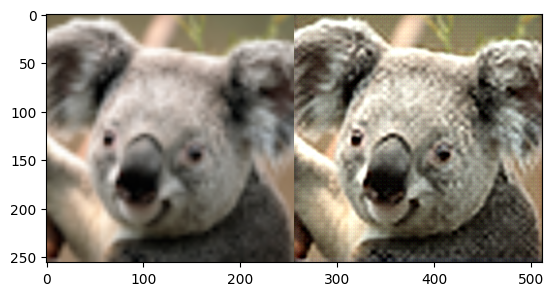

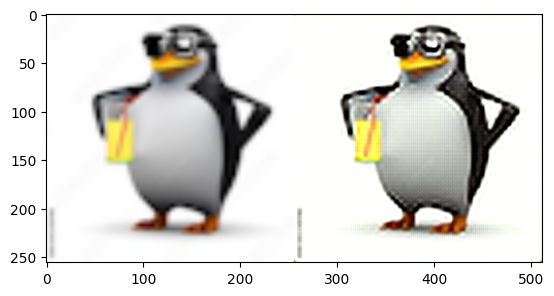

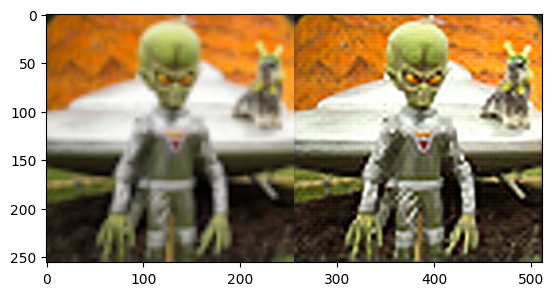

In [ ]:
img1 = upscale_image('koala.png', Display_Image = True)
img2 = upscale_image('penguin.png', Display_Image = True)
img3 = upscale_image('alien.png', Display_Image = True)